# 1. Imports

In [1]:
import locale

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
import seaborn as sns

from datetime import datetime

from math import floor



# 2. Settings

In [2]:
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')
plt.style.use('ggplot')
RANDOM_SEED = 0

# 3. Loading Data

In [3]:
def read_transport_data(filename):
    types_mapping = {
        'Numer / oznaczenie linii' : str,                                     
        'Wariant linii' : str,                                              
        'Kurs' : str,                                                        
        'Oznaczenie brygady' : str,
        'Czas rzeczywisty odjazdu wg. rozkładu' : str,                              
        'Czas odjazdu z przystanku' : str,
    }

    df = pd.read_csv(filename, sep=';', dtype=types_mapping)
    df = df.drop(columns='Data')
    
    names_mapping = {
        'Numer / oznaczenie linii' : 'Nr linii',                                     
        # 'Wariant linii'                                                    
        # 'Kurs'                                                                
        # 'Oznaczenie brygady'                                                  
        # 'Numer taborowy'                                                     
        # 'Nazwa przystanku'                                                    
        # 'Numer przystanku'                                                   
        'Czas rzeczywisty odjazdu wg. rozkładu' : 'Rzeczywisty czas odjazdu',                              
        'Czas odjazdu z przystanku' : 'Rozkładowy czas odjazdu',                                      
        'Liczba pasażerów w pojeździe przed przystankiem (dane skorygowane)' : 'Liczba pasaz. przed',  
        'Liczba osób które wysiadły (dane skorygowane)' : 'Liczba wysiadających pasaz.',                       
        'Liczba osób które wsiadły (dane skorygowane)' : 'Liczba wsiadajacych pasaz.',                     
        'Liczba pasażerów w pojeździe po odjeździe (dane skorygowane)' : 'Liczba pasaz. po odjezdzie'
    }
    df.rename(columns=names_mapping, inplace=True)

    

    return df

In [4]:
df = read_transport_data('./data/SZP-2021-09-03.csv')

# 4. Inspecting Data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177546 entries, 0 to 177545
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   Nr linii                     177546 non-null  object
 1   Wariant linii                177546 non-null  object
 2   Kurs                         177546 non-null  object
 3   Oznaczenie brygady           177546 non-null  object
 4   Numer taborowy               177546 non-null  int64 
 5   Nazwa przystanku             177546 non-null  object
 6   Numer przystanku             177546 non-null  int64 
 7   Rzeczywisty czas odjazdu     172273 non-null  object
 8   Rozkładowy czas odjazdu      177546 non-null  object
 9   Liczba pasaz. przed          177546 non-null  int64 
 10  Liczba wysiadających pasaz.  177546 non-null  int64 
 11  Liczba wsiadajacych pasaz.   177546 non-null  int64 
 12  Liczba pasaz. po odjezdzie   177546 non-null  int64 
dtypes: int64(6), o

In [6]:
df.sample(5)

,Nr linii,Wariant linii,Kurs,Oznaczenie brygady,Numer taborowy,Nazwa przystanku,Numer przystanku,Rzeczywisty czas odjazdu,Rozkładowy czas odjazdu,Liczba pasaz. przed,Liczba wysiadających pasaz.,Liczba wsiadajacych pasaz.,Liczba pasaz. po odjezdzie
58613,176,TP-BUD,20:59,3,9403,Brzezińska,1,21:01:00,21:02,2,0,0,2
167058,N03,TP-NOW,23:49,357,9344,Żerań FSO,2,00:45:00,00:49,25,0,0,25
175490,Z23,TP-OKO,13:45,6,9852,Młynów,1,14:02:00,14:02,27,8,4,23
15039,123,TP-DWK,05:47,4,9438,Wiatraczna,22,05:57:00,05:57,6,0,0,6
173481,Z23,TP-NBM,20:30,2,9846,Dalibora,2,20:39:00,20:41,12,0,0,12


In [7]:
df.describe()

,Numer taborowy,Numer przystanku,Liczba pasaz. przed,Liczba wysiadających pasaz.,Liczba wsiadajacych pasaz.,Liczba pasaz. po odjezdzie
count,177546.000000,177546.000000,177546.000000,177546.000000,177546.000000,177546.000000
mean,9513.375953,3.437903,12.060711,1.560435,1.570534,12.070810
std,265.044802,7.857952,12.341741,3.136487,3.192504,12.335713
min,9061.000000,1.000000,-3.000000,0.000000,0.000000,0.000000
25%,9319.000000,1.000000,4.000000,0.000000,0.000000,4.000000
50%,9452.000000,2.000000,9.000000,0.000000,0.000000,9.000000
75%,9806.000000,3.000000,16.000000,2.000000,2.000000,16.000000
max,9955.000000,88.000000,133.000000,124.000000,110.000000,133.000000


# 4.1. Check data

In [8]:
counter = 0
counter += len(df.loc[df['Liczba pasaz. przed'] - df['Liczba wysiadających pasaz.'] + df['Liczba wsiadajacych pasaz.'] != df['Liczba pasaz. po odjezdzie']])
counter += len(df[df['Liczba pasaz. przed'] < 0])
print(f'Amount of invalid data: {counter}')

Amount of invalid data: 2


# 4.2. Remove errors

In [9]:
df.drop(df[df['Liczba pasaz. przed'] < 0].index, inplace=True) # remove invlid amout of passengers

df.drop(df[df['Kurs'].str[:2] > '23'].index, inplace= True)

is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]

df.drop(df[row_has_NaN].index, inplace=True)


# 4.3. Parse data

In [10]:
def make_date_one_type(x):
    return pd.Timestamp(x)

In [11]:
df['Kurs'] = df['Kurs'].apply(lambda x: make_date_one_type(x))
df['Rzeczywisty czas odjazdu'] = df['Rzeczywisty czas odjazdu'].apply(lambda x: make_date_one_type(x))
df['Rozkładowy czas odjazdu'] = df['Rozkładowy czas odjazdu'].apply(lambda x: make_date_one_type(x))

In [12]:
df['Godzina odjazdu'] = df['Rozkładowy czas odjazdu'].apply(lambda x: x.hour + x.minute/60 + x.second/3600)
df['Godzina odjazdu przedział'] = df['Rozkładowy czas odjazdu'].apply(lambda x: x.hour * 4 + floor(x.minute/15))

# 4.4. New data

In [13]:
trans_type = []
for nr in df['Nr linii']:
    if nr.isnumeric():
        trans_type.append('autobus')
    elif nr[0] == 'N':
        trans_type.append('nocny')
    elif nr[0] == 'Z':
        trans_type.append('zastepczy')
    else:
        trans_type.append('inny')
df['Typ'] = trans_type

In [14]:
df.sample(3)

,Nr linii,Wariant linii,Kurs,Oznaczenie brygady,Numer taborowy,Nazwa przystanku,Numer przystanku,Rzeczywisty czas odjazdu,Rozkładowy czas odjazdu,Liczba pasaz. przed,Liczba wysiadających pasaz.,Liczba wsiadajacych pasaz.,Liczba pasaz. po odjezdzie,Godzina odjazdu,Godzina odjazdu przedział,Typ
3804,103,TO-DWT,2021-12-27 16:54:00,4,9453,Metro Młynów,1,2021-12-27 17:24:00,2021-12-27 17:25:00,10,5,1,6,17.416667,69,autobus
141810,525,TP-MIE,2021-12-27 07:11:00,6,9823,Międzynarodowa,2,2021-12-27 07:27:00,2021-12-27 07:27:00,50,2,5,53,7.450000,29,autobus
58056,176,TP-CHS,2021-12-27 22:41:00,2,9412,Marywilska-Las,2,2021-12-27 22:53:00,2021-12-27 22:52:00,9,0,0,9,22.866667,91,autobus


## 4.5 Clustering

In [15]:
def find_clusters(speeds, iterations, df, column):
    k = len(speeds)
    data = np.array(df[column]).reshape(1,-1).T
    clusters = KMeans(
        n_clusters = k,
        max_iter = iterations,
        random_state = RANDOM_SEED
    ).fit(data)
    
    cc, *_ = clusters.cluster_centers_.reshape(1,k)
    cc_ord = np.argsort(cc)
    class_mapping = dict(zip(cc_ord, speeds))
    
    df['class'] = clusters.labels_
    df['class'] = df['class'].map(class_mapping)
    
    return df
    

In [47]:
# crowding = ['pusto','małe zatłoczenie', 'średnie zatłoczenie', 'duze zatłoczenie', 'olbrzymie zatłoczenie']
crowding = [0, 1, 2, 3, 4]
iterations = 10

df = find_clusters(crowding, iterations, df, 'Liczba pasaz. po odjezdzie')

<Figure size 720x576 with 0 Axes>

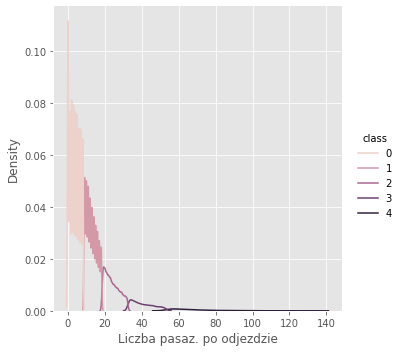

In [48]:
plt.figure(figsize=(10, 8))
ax = sns.displot(
    df,
    x='Liczba pasaz. po odjezdzie',
    hue='class',
    kind='kde'
)

## 5. Classification

In [49]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import datetime as dt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from mlxtend.evaluate import bootstrap_point632_score
from mlxtend.evaluate import BootstrapOutOfBag
from mlxtend.evaluate import bootstrap

import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
df2 = df[:1000]
len(df2)

1000

In [51]:
df2 = df2.loc[df['Typ']=='autobus']
df2 = df2.drop(columns=['Wariant linii','Nazwa przystanku', 'Numer przystanku', 'Rzeczywisty czas odjazdu', 'Rozkładowy czas odjazdu', 'Kurs', 'Oznaczenie brygady','Typ'], inplace= False)
df2.sample(3)

,Nr linii,Numer taborowy,Liczba pasaz. przed,Liczba wysiadających pasaz.,Liczba wsiadajacych pasaz.,Liczba pasaz. po odjezdzie,Godzina odjazdu,Godzina odjazdu przedział,class
857,102,9450,10,2,6,14,12.116667,48,1
159,102,9415,6,0,0,6,9.766667,39,0
438,102,9415,5,0,1,6,18.483333,73,0


In [52]:
features = df2.columns[:-1]
print(features)

Index(['Nr linii', 'Numer taborowy', 'Liczba pasaz. przed',
       'Liczba wysiadających pasaz.', 'Liczba wsiadajacych pasaz.',
       'Liczba pasaz. po odjezdzie', 'Godzina odjazdu',
       'Godzina odjazdu przedział'],
      dtype='object')


In [53]:
X = df2.drop('class', axis=1, inplace= False)
X.sample(3)

,Nr linii,Numer taborowy,Liczba pasaz. przed,Liczba wysiadających pasaz.,Liczba wsiadajacych pasaz.,Liczba pasaz. po odjezdzie,Godzina odjazdu,Godzina odjazdu przedział
802,102,9450,12,3,2,11,10.416667,41
30,102,9415,2,1,0,1,5.966667,23
933,102,9450,21,11,0,10,14.533333,58


In [54]:
X.shape

(1000, 8)

In [55]:
y = df2["class"]
y.sample(3)

420    0
479    0
226    0
Name: class, dtype: int64

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## DecisionTreeClassifier

In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [58]:
def create_tree(x, x_test, y, y_test, depth = 3):  
    clf = DecisionTreeClassifier(max_depth = depth, random_state = 1)
    clf = clf.fit(x, y)
    err = accuracy_score(y_test, clf.predict(x_test))
    print("Accuracy: ", err)
    return err

In [59]:
tr1 = create_tree(X_train, X_test, y_train, y_test, depth = 2)

Accuracy:  0.996


In [60]:
model = DecisionTreeClassifier(max_depth = 3, random_state = 1)

In [61]:
#LeaveOneOut CrossValidation with negative mean absolute scores: the higher the scores, the lower mean absolute errors
scores1 = cross_validate(model, X_train, y_train, cv = LeaveOneOut(), n_jobs = -1, scoring = 'neg_mean_absolute_error', return_estimator = True)
err1 = accuracy_score(scores1['estimator'][scores1['test_score'].argmax()].predict(X_test),y_test)

In [62]:
#Bootstrap Out of Bag
scores2 = cross_validate(model, X_train, y_train, cv = BootstrapOutOfBag(n_splits=5, random_seed=456), n_jobs = -1, scoring = 'neg_mean_absolute_error', return_estimator = True)
err2 = accuracy_score(scores2['estimator'][scores2['test_score'].argmax()].predict(X_test),y_test)

In [64]:
#Repeated K-Fold
scores3 = cross_validate(model, X_train, y_train, n_jobs = -1, cv = RepeatedKFold(n_splits = 10, n_repeats = 2), scoring = 'neg_mean_absolute_error', return_estimator = True)
err3 = accuracy_score(scores3['estimator'][scores3['test_score'].argmax()].predict(X_test),y_test)

In [65]:
#K-Fold
scores4 = cross_validate(model, X_train, y_train, cv = KFold(10), n_jobs=-1, scoring = 'neg_mean_absolute_error',return_estimator = True)
err4 = accuracy_score(scores4['estimator'][scores4['test_score'].argmax()].predict(X_test), y_test)

In [68]:
print("------- Accuracy --------")
print(f"1. Accuracy LeaveOneOut {err1}")
print(f"2. Accuracy BootstrapOutOfBag {err2}")
print(f"3. Accuracy RepeatedKFold {err3}")
print(f"4. Accuracy KFold {err4}")

------- Accuracy --------
1. Accuracy LeaveOneOut 1.0
2. Accuracy BootstrapOutOfBag 1.0
3. Accuracy RepeatedKFold 1.0
4. Accuracy KFold 1.0
